In [1]:
from llm.LLMModel import *
from ner.llm_ner.prompt_techniques.pt_abstract import PromptTechnique
from ner.llm_ner.prompt_techniques.pt_discussion import PT_OutputList
from ner.llm_ner.prompt_techniques.pt_gpt_ner import PT_GPT_NER
from ner.llm_ner.prompt_techniques.pt_wrapper import PT_Wrapper
from ner.llm_ner.few_shots_techniques import *
from ner.llm_ner.ResultInstance import load_all_results, load_result
%reload_ext autoreload
%autoreload 2

2023-11-16 09:37:46.253249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 09:37:46.819542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /home/ketl2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ketl2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ketl2/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/home/ketl2/.local/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbyte

/home/ketl2/.local/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


In [47]:

df_results = load_all_results()

/home/ketl2/.local/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ketl2/.local/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ketl2/.local/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ketl2/.local/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ketl2/.local/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ketl2/.local/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invali

In [49]:
df_results[df_results['prompt_technique'] == 'wrapper']

,f1_mean,f1_conf_inter,model,noshots,prompt_technique,few_shot_tecnique,nb_few_shots,precision,verifier,len_data_train,len_data_test,nb_test_run,confidence_interval,distribution_used,precision_mean,precision_conf_inter,recall_mean,recall_conf_inter
39,0.691,"(0.631, 0.751)",mistral-7b-v0.1,False,wrapper,sentence,5,no-precision,None,1538,50,3,0.95,Student,0.632,"(0.585, 0.678)",0.446,"(0.382, 0.511)"
34,0.656,"(0.631, 0.681)",mistral-7b-v0.1-ft-wrapper-5000-Q5_0,True,wrapper,no-shots,5,True,None,1538,50,10,0.95,Student,0.657,"(0.629, 0.685)",0.662,"(0.641, 0.682)"
2,0.641,"(0.628, 0.654)",mistral-7b-v0.1-ft-wrapper-2000-Q5_0,True,wrapper,no-shots,5,True,None,1538,50,10,0.95,Student,0.650,"(0.638, 0.662)",0.634,"(0.620, 0.648)"
35,0.626,"(0.607, 0.645)",mistral-7b-v0.1-ft-wrapper-5000-Q5_0,True,wrapper,sentence,5,True,None,1538,50,10,0.95,Student,0.627,"(0.607, 0.647)",0.629,"(0.610, 0.648)"
3,0.626,"(0.611, 0.641)",mistral-7b-v0.1-ft-wrapper-2000-Q5_0,True,wrapper,sentence,5,True,None,1538,50,10,0.95,Student,0.631,"(0.615, 0.647)",0.623,"(0.608, 0.637)"
36,0.620,"(0.607, 0.634)",mistral-7b-v0.1-ft-wrapper-5000-Q5_0,True,wrapper,entity,5,True,None,1538,50,10,0.95,Student,0.624,"(0.609, 0.639)",0.619,"(0.606, 0.632)"
24,0.591,"(0.511, 0.671)",llama-2-13b,False,wrapper,sentence,5,no-precision,None,1538,50,3,0.95,Student,0.450,"(0.300, 0.600)",0.358,"(0.254, 0.462)"
40,0.574,"(0.545, 0.603)",mistral-7b-v0.1,False,wrapper,entity,5,yes,None,1538,50,3,0.95,Student,0.496,"(0.479, 0.514)",0.364,"(0.332, 0.397)"
42,0.571,"(0.385, 0.757)",mistral-7b-v0.1,False,wrapper,entity,5,no-precision,None,1538,50,3,0.95,Student,0.523,"(0.316, 0.730)",0.385,"(0.338, 0.432)"
37,0.568,"(0.547, 0.589)",mistral-7b-v0.1-ft-wrapper-5000-Q5_0,True,wrapper,random,5,True,None,1538,50,10,0.95,Student,0.559,"(0.535, 0.583)",0.581,"(0.562, 0.600)"


## Show results for finetuned models

In [72]:

df_results['finetuned'] = df_results['model'].map(lambda s : 'ft' in s)
df_results['nb_samples_tested'] = df_results['nb_test_run'] * df_results['len_data_test']
ft_results = df_results[df_results['finetuned']]
ft_results = ft_results[['f1_mean', 'f1_conf_inter', 'prompt_technique', 'model', 'noshots', 'few_shot_tecnique','nb_few_shots', 'nb_samples_tested']]
ft_results['model_base'] = ft_results['model'].map(lambda s : '-'.join(s.split('-')[:-4]))
ft_results['nb_train_samples'] = ft_results['model'].map(lambda s : s.split('-')[-2])
ft_results = ft_results.sort_values(['prompt_technique',	'few_shot_tecnique', 'f1_mean'], ascending=False)

In [73]:
# ['f1_mean', 'f1_conf_inter', 'prompt_technique', 'few_shot_tecnique',
    #    'nb_few_shots', 'nb_samples_tested', 'model_base', 'nb_train_samples',
    #    'finetuned']
grouped = ft_results.groupby(['prompt_technique', 'few_shot_tecnique', 'noshots', 
       'nb_few_shots', 'nb_samples_tested', 'model_base', 'nb_train_samples'])
grouped 

idx_max = grouped['f1_mean'].idxmax()

ft_cleaned = ft_results.loc[idx_max].sort_values('nb_train_samples', ascending=False)

df = ft_cleaned[ft_cleaned['nb_samples_tested'] == 500]
# Create dummy columns for 'few_shot_tecnique'
df.pivot(index=['model_base','prompt_technique','noshots',
        'nb_train_samples'], columns='few_shot_tecnique', values= 'f1_mean')

few_shot_tecnique                                          entity  no-shots  \
model_base      prompt_technique noshots nb_train_samples                     
mistral-7b-v0.1 discussion       False   10000              0.802     0.823   
                                         2000               0.836     0.665   
                                 True    10000              0.144       NaN   
                                         2000                 NaN     0.679   
                wrapper          False   10000              0.468     0.363   
                                         2000               0.026     0.000   
                                 True    2000                 NaN     0.641   
                                         5000               0.620     0.656   

few_shot_tecnique                                          random  sentence  
model_base      prompt_technique noshots nb_train_samples                    
mistral-7b-v0.1 discussion       False   10000              0.799     0.732  
                                         2000               0.841     0.823  
                                 True    10000                NaN     0.330  
                                         2000                 NaN     0.636  
                wrapper          False   10000              0.445     0.457  
                                         2000               0.004     0.557  
                                 True    2000                 NaN     0.626  
                                         5000               0.568     0.626

## Show results for non finetuned models

In [56]:
df_results['finetuned'] = df_results['model'].map(lambda s : 'ft' in s)
df_results['nb_samples_tested'] = df_results['nb_test_run'] * df_results['len_data_test']
ft_results = df_results[~df_results['finetuned']]
ft_results = ft_results[['f1_mean', 'f1_conf_inter', 'prompt_technique', 'model', 'noshots', 'few_shot_tecnique','nb_few_shots', 'nb_samples_tested']]
ft_results = ft_results.sort_values(['prompt_technique',	'few_shot_tecnique', 'f1_mean'], ascending=False)

In [71]:
# ['f1_mean', 'f1_conf_inter', 'prompt_technique', 'few_shot_tecnique',
    #    'nb_few_shots', 'nb_samples_tested', 'model_base', 'nb_train_samples',
    #    'finetuned']
ft_results = ft_results[ft_results['model'] != 'none']
grouped = ft_results.groupby([ 'model', 'prompt_technique', 
       'nb_few_shots', 'nb_samples_tested','few_shot_tecnique', ])
grouped 

# idx_max = grouped['f1_mean'].idxmax()
# idx_max

# Create dummy columns for 'few_shot_tecnique'
ft_results.loc[idx_max].pivot(index=['model','prompt_technique', 'nb_few_shots','nb_samples_tested',
        ], columns='few_shot_tecnique', values= 'f1_mean')

few_shot_tecnique                                                                entity  \
model           prompt_technique                 nb_few_shots nb_samples_tested           
llama-2-13b     wrapper                          5            150                 0.506   
mistral-7b-v0.1 @@##                             5            150                 0.379   
                discussion                       5            150                 0.632   
                                                 10           500                 0.371   
                multi_prompt-get-entities-tagger 3            50                    NaN   
                                                              150                   NaN   
                                                              200                   NaN   
                wrapper                          5            150                 0.574   

few_shot_tecnique                                                                no-shots  \
model           prompt_technique                 nb_few_shots nb_samples_tested             
llama-2-13b     wrapper                          5            150                     NaN   
mistral-7b-v0.1 @@##                             5            150                     NaN   
                discussion                       5            150                     NaN   
                                                 10           500                     0.0   
                multi_prompt-get-entities-tagger 3            50                      NaN   
                                                              150                     NaN   
                                                              200                     NaN   
                wrapper                          5            150                     NaN   

few_shot_tecnique                                                                random  \
model           prompt_technique                 nb_few_shots nb_samples_tested           
llama-2-13b     wrapper                          5            150                 0.351   
mistral-7b-v0.1 @@##                             5            150                   NaN   
                discussion                       5            150                 0.504   
                                                 10           500                   NaN   
                multi_prompt-get-entities-tagger 3            50                    NaN   
                                                              150                   NaN   
                                                              200                   NaN   
                wrapper                          5            150                 0.475   

few_shot_tecnique                                                                sentence  
model           prompt_technique                 nb_few_shots nb_samples_tested            
llama-2-13b     wrapper                          5            150                   0.591  
mistral-7b-v0.1 @@##                             5            150                   0.452  
                discussion                       5            150                   0.595  
                                                 10           500                   0.386  
                multi_prompt-get-entities-tagger 3            50                    0.497  
                                                              150                   0.438  
                                                              200                   0.425  
                wrapper                          5            150                   0.691

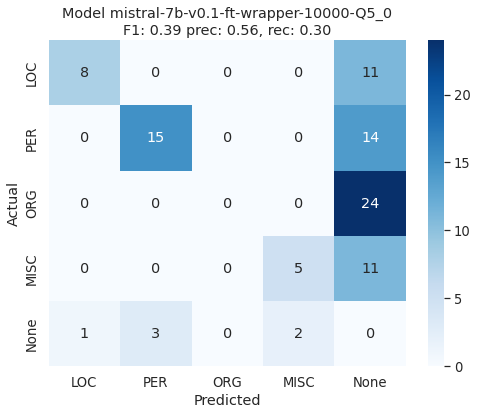

0
[['Lara', 'PER'], ['Australia', 'LOC'], ['Ian Healy', 'PER']]
[('World Series', 'MISC')]
--------------------------------------------
1
[['Indonesia', 'LOC'], ['Ronny Wabia', 'PER'], ['Widodo Putra', 'PER']]
[('Ronny Wabia', 'PER'), ('Widodo Putra', 'PER')]
--------------------------------------------
2
[]
[]
--------------------------------------------
3
[['Major', 'PER'], ['office-Conservatives', 'MISC']]
[('John Major', 'PER')]
--------------------------------------------
4
[['NYMEX', 'ORG']]
[]
--------------------------------------------
5
[['YIT', 'ORG'], ['Reuters', 'ORG']]
[]
--------------------------------------------
6
[]
[]
--------------------------------------------
7
[['Pace', 'PER'], ['Ian Harvey', 'PER'], ['Victoria', 'LOC']]
[]
--------------------------------------------
8
[['Patasse', 'PER'], ['Central Africa', 'LOC']]
[('Patasse', 'PER'), ('Central Africa', 'LOC')]
--------------------------------------------
9
[]
[]
--------------------------------------------
1

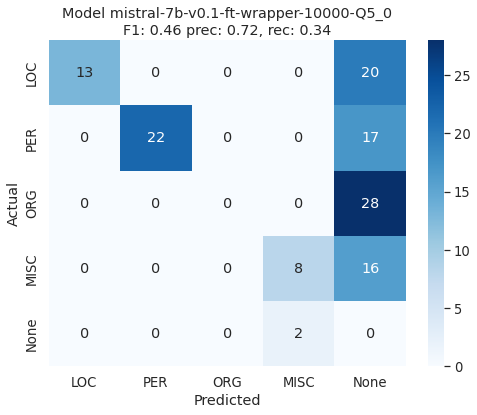

0
[['Glenn Lawhon', 'PER'], ['Florida', 'LOC'], ['Mills', 'PER'], ['GMT', 'MISC'], ['Lester Lawhon', 'PER']]
[]
--------------------------------------------
1
[['Rashid', 'PER'], ['Greece', 'LOC']]
[]
--------------------------------------------
2
[['London Newsroom', 'ORG']]
[]
--------------------------------------------
3
[['Swede', 'MISC'], ['Kennet Andersson', 'PER'], ['Russian', 'MISC'], ['Igor Kolyvanov', 'PER'], ['Bologna', 'ORG'], ['Piacenza', 'ORG'], ['AC Milan', 'ORG']]
[]
--------------------------------------------
4
[['Yegor Stroyev', 'PER'], ['Yeltsin', 'PER']]
[]
--------------------------------------------
5
[['NYC', 'MISC'], ['Euro', 'MISC']]
[]
--------------------------------------------
6
[['Paul Crofts', 'PER'], ['Tony', 'PER'], ['New South Wales Supreme Court', 'ORG']]
[('Tony', 'PER')]
--------------------------------------------
7
[['Hakme', 'PER'], ['Brazil', 'LOC']]
[('Hakme', 'PER'), ('Brazil', 'LOC')]
--------------------------------------------
8
[['Suu Ky

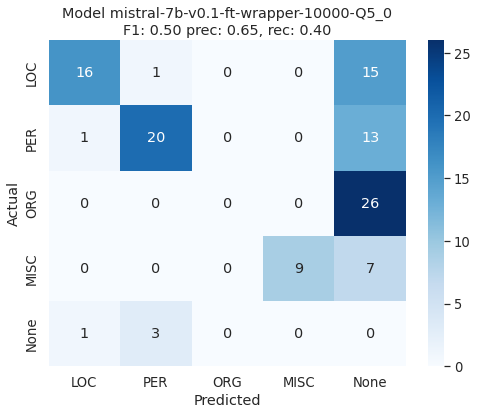

0
[['NZ', 'LOC'], ['Peters', 'PER'], ['Nat', 'PER'], ['Lab', 'PER']]
[('NZ', 'LOC'), ('Peters', 'PER')]
--------------------------------------------
1
[]
[]
--------------------------------------------
2
[]
[]
--------------------------------------------
3
[['BILO', 'MISC'], ['Malysia', 'LOC'], ['Kuala Lumpur', 'LOC'], ['Johor Bahru', 'LOC']]
[('BILO', 'MISC'), ('Malaysia', 'LOC'), ('Kuala Lumpur', 'LOC'), ('Johor Bahru', 'LOC')]
--------------------------------------------
4
[['LUXEMBOURG', 'LOC']]
[('LUXEMBOURG', 'LOC')]
--------------------------------------------
5
[['Busang', 'ORG']]
[]
--------------------------------------------
6
[['Polish', 'MISC']]
[('Pope', 'PER')]
--------------------------------------------
7
[['League', 'ORG']]
[]
--------------------------------------------
8
[['Rubin', 'PER'], ['U.S.', 'LOC'], ['Sakakibara', 'PER'], ['United States', 'LOC']]
[]
--------------------------------------------
9
[['Weah', 'PER'], ['Costa', 'PER']]
[('Weah', 'PER'), ('Costa',

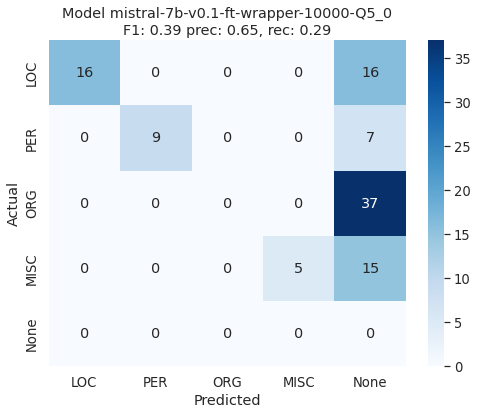

0
[['Munich Re', 'ORG'], ['DAX', 'MISC']]
[('DAX', 'MISC')]
--------------------------------------------
1
[['Rangoon', 'LOC']]
[]
--------------------------------------------
2
[['Ireland', 'LOC'], ['World Cup', 'MISC'], ['European', 'MISC'], ['Germany', 'LOC'], ['Irish', 'MISC'], ['England', 'LOC']]
[]
--------------------------------------------
3
[['Madlen Brigger-Summermatter', 'PER'], ['Switzerland', 'LOC']]
[('Madlen Brigger-Summermatter', 'PER'), ('Switzerland', 'LOC')]
--------------------------------------------
4
[['Office of Fair Trade', 'ORG'], ['British Airways', 'ORG'], ['American', 'ORG']]
[]
--------------------------------------------
5
[['Liberian', 'MISC'], ['George Weah', 'PER'], ['Milan', 'ORG'], ['Roberto Baggio', 'PER'], ['Montenegrin', 'MISC'], ['Dejan Savicevic', 'PER']]
[('George Weah', 'PER'), ('Roberto Baggio', 'PER'), ('Montenegrin', 'MISC'), ('Dejan Savicevic', 'PER')]
--------------------------------------------
6
[['Placer Dome Inc', 'ORG'], ['Santa Fe'

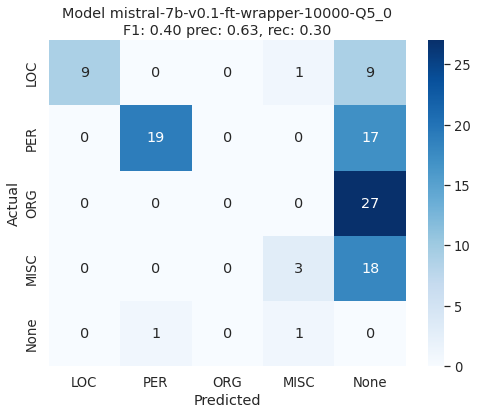

0
[]
[]
--------------------------------------------
1
[['Internet', 'MISC'], ['Mongolia', 'LOC']]
[]
--------------------------------------------
2
[['British Airways-American', 'MISC']]
[]
--------------------------------------------
3
[]
[]
--------------------------------------------
4
[]
[]
--------------------------------------------
5
[['Singapore', 'LOC'], ['Tan Kong Yam', 'PER'], ['National University of Singapore', 'ORG']]
[]
--------------------------------------------
6
[]
[]
--------------------------------------------
7
[['Brazilians', 'MISC']]
[]
--------------------------------------------
8
[['Japan', 'LOC']]
[('Japan', 'LOC')]
--------------------------------------------
9
[['Veronica Brenner', 'PER'], ['Canada', 'LOC'], ['Tignes', 'LOC'], ['French', 'MISC']]
[]
--------------------------------------------
10
[]
[]
--------------------------------------------
11
[['Australia', 'LOC'], ['Barbarians', 'ORG'], ['European', 'MISC']]
[]
------------------------------------

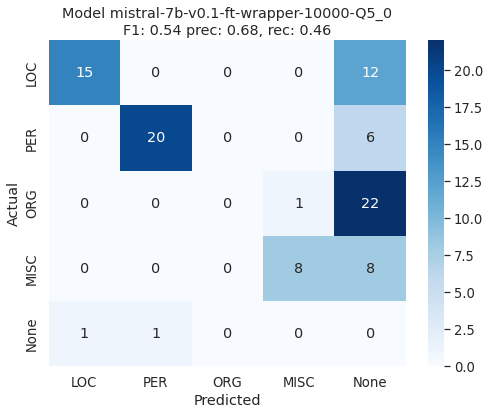

0
[['Australia', 'LOC'], ['West Indies', 'LOC']]
[]
--------------------------------------------
1
[['Internet', 'MISC'], ['Marc Pearl', 'PER'], ['Information Technology Association of America', 'ORG'], ['U.S.', 'LOC']]
[]
--------------------------------------------
2
[['South Africa', 'LOC'], ['North West', 'LOC']]
[('South Africa', 'LOC'), ('North West', 'LOC')]
--------------------------------------------
3
[['Polish', 'MISC'], ['Boxmeer', 'PER'], ['Heineken', 'ORG'], ['Poland', 'LOC']]
[('Polish', 'MISC'), ('Poland', 'LOC')]
--------------------------------------------
4
[['Paul Keating', 'PER']]
[('Paul Keating', 'PER')]
--------------------------------------------
5
[]
[]
--------------------------------------------
6
[['U.S.', 'LOC']]
[]
--------------------------------------------
7
[['Lang', 'PER'], ['Britain', 'LOC'], ['Office of Fair Trading', 'ORG']]
[('Lang', 'PER'), ('Britain', 'LOC')]
--------------------------------------------
8
[['Japan', 'LOC'], ['Syrian', 'MISC'], 

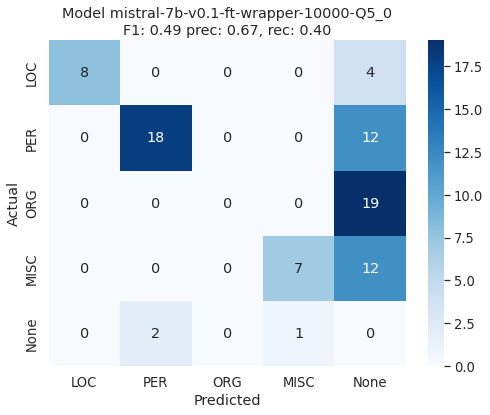

0
[['Irish Republican Army', 'ORG'], ['Belfast', 'LOC']]
[]
--------------------------------------------
1
[['BOJ', 'ORG']]
[]
--------------------------------------------
2
[['Canadian', 'MISC']]
[('Canadian', 'MISC')]
--------------------------------------------
3
[['Moin Khan', 'PER'], ['Astle', 'PER'], ['Harris', 'PER']]
[('Moin Khan', 'PER'), ('Astle', 'PER'), ('Harris', 'PER')]
--------------------------------------------
4
[]
[]
--------------------------------------------
5
[]
[]
--------------------------------------------
6
[['Indian', 'MISC'], ['Ayodhya', 'LOC'], ['Hindu-Moslem', 'MISC']]
[('Indian', 'MISC'), ('Ayodhya', 'LOC'), ('Hindu-Moslem', 'MISC')]
--------------------------------------------
7
[['Japan', 'LOC']]
[('Japan', 'LOC')]
--------------------------------------------
8
[['Bitar', 'PER']]
[]
--------------------------------------------
9
[]
[]
--------------------------------------------
10
[['James Love', 'PER'], ['Washington-based', 'MISC'], ['Consumer Projec

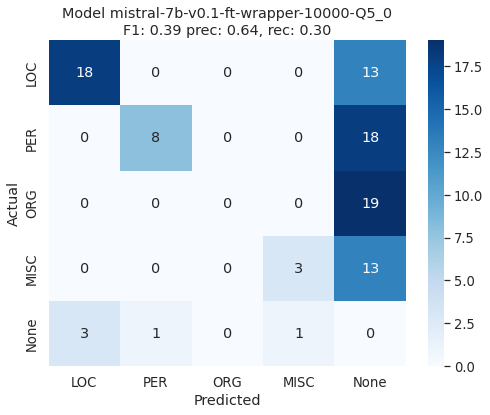

0
[['Weah', 'PER'], ['Milan', 'ORG'], ['Rosenborg', 'ORG'], ['Norway', 'LOC']]
[('Weah', 'PER'), ('Norway', 'LOC')]
--------------------------------------------
1
[]
[]
--------------------------------------------
2
[['Havel', 'PER']]
[]
--------------------------------------------
3
[['WOOLMER', 'PER'], ['KANPUR', 'LOC']]
[]
--------------------------------------------
4
[['Norilsk', 'ORG'], ['Chernyshev', 'PER']]
[]
--------------------------------------------
5
[['Yegor Stroyev', 'PER'], ['Yeltsin', 'PER']]
[]
--------------------------------------------
6
[['Little', 'PER'], ['Queenslander', 'MISC'], ['Daniel Herbert', 'PER']]
[]
--------------------------------------------
7
[]
[]
--------------------------------------------
8
[['U.S.', 'LOC']]
[]
--------------------------------------------
9
[['Morris', 'PER']]
[]
--------------------------------------------
10
[['New Mexico Activities Association', 'ORG'], ['Cito', 'PER']]
[('Albuquerque', 'LOC')]
------------------------------

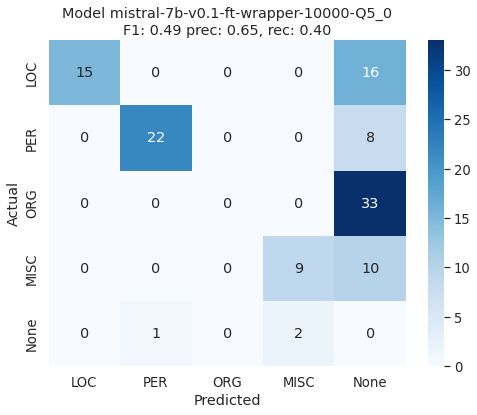

0
[['Bochum', 'ORG'], ['Stickroth', 'PER'], ['Wosz', 'PER'], ['Bayer Leverkusen', 'ORG'], ['Kirsten', 'PER'], ['Ramelow', 'PER']]
[('Stickroth', 'PER'), ('Wosz', 'PER'), ('Kirsten', 'PER'), ('Ramelow', 'PER')]
--------------------------------------------
1
[['Spanish', 'MISC'], ['Santiago Bernabeu stadium', 'LOC'], ['Real Madrid-Barcelona', 'MISC'], ['Madrid', 'LOC'], ['El Mundo', 'ORG']]
[]
--------------------------------------------
2
[['Bangui', 'LOC'], ['French', 'MISC']]
[('Bangui', 'LOC'), ('French', 'MISC')]
--------------------------------------------
3
[['Chile', 'LOC'], ['Mexico', 'LOC'], ['Finance', 'ORG'], ['Eduardo Aninat', 'PER']]
[('Chile', 'LOC'), ('Mexico', 'LOC'), ('Eduardo Aninat', 'PER')]
--------------------------------------------
4
[['Britain', 'LOC']]
[]
--------------------------------------------
5
[]
[]
--------------------------------------------
6
[['Hyundai Heavy', 'ORG'], ['Koram Bank', 'ORG']]
[]
--------------------------------------------
7
[]
[]
----

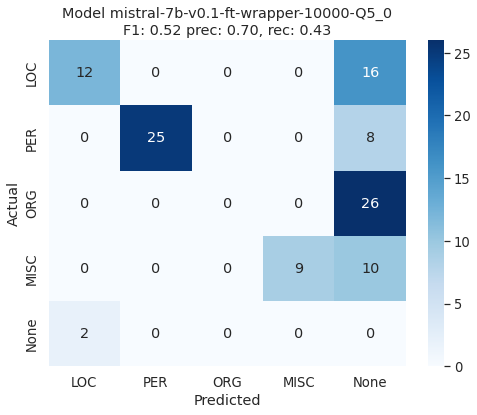

0
[['Brazil', 'LOC'], ['Farid Hakme', 'PER'], ['Brazilian Plastic Surgery Society', 'ORG'], ['SBCP', 'ORG']]
[]
--------------------------------------------
1
[['United States', 'LOC'], ['Egyptian', 'MISC'], ['African', 'MISC']]
[('Egyptian', 'MISC'), ('African', 'MISC')]
--------------------------------------------
2
[['Chile', 'LOC'], ['Aninat', 'PER']]
[('Chile', 'LOC'), ('Aninat', 'PER')]
--------------------------------------------
3
[['National Weather Service', 'ORG'], ['U.S.', 'LOC']]
[]
--------------------------------------------
4
[]
[]
--------------------------------------------
5
[['1993 World Cup', 'MISC'], ['Europa Cup', 'MISC'], ['Goetschl', 'PER'], ['World Cup', 'MISC']]
[('Goetschl', 'PER'), ('World Cup', 'MISC')]
--------------------------------------------
6
[['Nader Jokhadar', 'PER'], ['Ammar Awad', 'PER'], ['Kenichi Shimokawa', 'PER']]
[('Ammar Awad', 'PER'), ('Kenichi Shimokawa', 'PER')]
--------------------------------------------
7
[['German', 'MISC'], ['EU', 

In [74]:
model  = "mistral-7b-v0.1-ft-wrapper-10000-Q5_0"
result = load_result(model, PT_Wrapper.name(), FST_Sentence.name(), with_precision = "10_False")

for r in result.res_insts :
    r.show_cm()
    r.analyse_results()

In [ ]:
r.f1

In [ ]:
from ner.Datasets.Conll2003Dataset import load_conll_dataset
data = load_conll_dataset(cleaned = True)
[(d['text'], d['spans']) for d in data if str(d['spans']) == """[['Switzerland', 'LOC'], ["Alfonse D'Amato", 'PER'], ['U.S. Senate Banking Committee', 'ORG'], ['Poland', 'LOC'], ['Polish', 'MISC'], ['Swiss', 'MISC'], ['Poland', 'LOC']]"""]

In [ ]:
[(d['text'], d['spans']) for d in data if 'Hansenne' in d['text']]